# Controls Application Analysis

Here we dump metrics from all applications, console, java, etc. and collect them in a single data frame. This allows us to explore the data and discover insights that would be difficult to know otherwise.

## Single Source of Truth

We will keep all data in the `app_data.json` file. So, if you generate data that could be used for future analysis, add it to the `app_data` data frame and then write the data frame back to the `app_data.json` file.

```python
# Example data concatenation
# app_data = pd.concat([app_data, line_data])
app_data.to_json("app_data.json", orient="records", indent=2)
```

### Output to JSON

If you uncomment this, it will output to `test.json`. Use this as a guide to update the `app_data.json` file. Check the changes with a print or the `test.json` file before committing changes to `app_data.json`.

In [1]:
# app_data = pd.read_json('app_data.json')
# app_data = app_data.merge(line_data, on="program")
# app_data.to_json('test.json', orient='records', indent=2)

## Imports

To install these you can run `python3 -m pip install -r requirements.txt`.

In [2]:
import pandas as pd
# Even though we don't use this, it has useful defaults, so let's keep it.
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit

In [3]:
app_data = pd.read_json('app_data.json')
lines = np.asarray(app_data["count"])
# Remove zero-line entries
lines_nonzero = lines[np.where(app_data["count"]!=0)]

In [4]:
# Apply fit to data
def func(x, a, b, c):
    return a * np.exp(-1.0*(x/b)) + c

#x = np.linspace(0, np.size(lines_nonzero)-1, np.size(lines_nonzero))


Decay constant is 3659.1106786764194
Total lines of code up to cutoff is 2617567


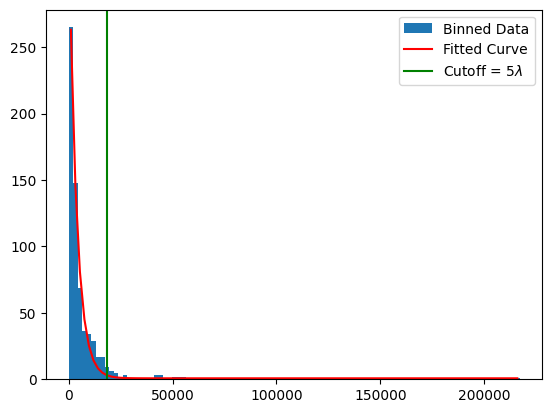

In [5]:
x = np.linspace(0, lines_nonzero.size - 1, lines_nonzero.size)
nbins = 100

n, bin_borders, _ = plt.hist(lines_nonzero, nbins, label="Binned Data")
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
p0 = [1, 1E2, 1]
popt, pcov = curve_fit(func, bin_centers, n, p0)
plt.plot(bin_centers, func(bin_centers, *popt), 'r-', label="Fitted Curve")
#plt.xlim(0,50000)
#plt.gca().set_yscale('log')
cutoff = 5 # units of fit characteristic decay constant
plt.axvline(x = cutoff*popt[1], ymin = 0, ymax = 1, color='green', label = f"Cutoff = {cutoff}"+r"$\lambda$")
plt.legend()

print(f"Decay constant is {popt[1]}")

# Compute total lines of code within the cutoff
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
# Find index that is nearest to the cutoff
#find_nearest(lines_nonzero, func(x,*popt))
cutoff_index = np.where(lines_nonzero == find_nearest(lines_nonzero, func(x,*popt)))[0][0]
lines_at_cutoff = np.sum(lines_nonzero[0:cutoff_index])
print(f"Total lines of code up to cutoff is {lines_at_cutoff}")

In [6]:
# Some statistics to see what's interesting
mean = np.mean(lines_nonzero)
median = np.median(lines_nonzero)
mode = stats.mode(lines_nonzero)[0]
sum = np.sum(lines_nonzero)
max = np.max(lines_nonzero)
print(f"Mean: {mean:.0f}, Median: {median:.0f}, Mode: {mode:.0f}, Sum: {sum:.0f}, Max: {max}")

Mean: 7050, Median: 2869, Mode: 242, Sum: 4660176, Max: 216997


In [7]:
# Determine PA# nearest to median
median_index = np.where(lines_nonzero == find_nearest(lines_nonzero, np.median(lines_nonzero)))[0][0]
app_data["program"][median_index]

'pa0717'

#### Ideas:
- Remove unused applications from dataset, if possible (i.e. not mapped to index page, not frequently used over time frame, Linac)
- Weight applications by priority (usage stats and interview criticality), redo analysis to determine window
- Use exponential fit, choose windows as integer multiples fit characteristic time constant (instead of standard deviation)

Maybe for CD-1, do first and third idea above. Priority weighting can refine estimate for CD-2.

John: effort is not linear with lines-of-code. Really wants to see how long it takes to port median application.

In [8]:
#all_data = pd.concat([df, lineCount['count']], axis=1, join='outer')